## ResNet Deployment in London's dataset

In the Human Scream Detection project, particularly in the "Deployment" phase, our objective is to leverage our most effective deep learning model and apply it to a new dataset to assess its performance. Imagine if our training dataset was sourced from New York City; our aim now is to ensure that this model performs effectively when implemented in London. This adaptation is crucial for optimizing surveillance systems tailored to London's specific needs and environmental conditions. Our goal is to achieve robust performance in identifying scream events, thereby enhancing public safety and security through reliable detection capabilities in urban settings like London.

In [1]:
#Installing the needed libraries
!pip install librosa tensorflow matplotlib

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Load New York Dataset

In [4]:
data_path = "/content/drive/My Drive/DeepLearning/code/dataset/"

X_NY_train = np.load(data_path + 'X_train_da.npy')
y_NY_train = np.load(data_path + 'y_train_da.npy')
X_NY_val = np.load(data_path + 'X_val.npy')
X_NY_test = np.load(data_path + 'X_test.npy')
y_NY_val = np.load(data_path + 'y_val.npy')
y_NY_test = np.load(data_path + 'y_test.npy')

### Load London Dataset

In [5]:
data_path = "/content/drive/My Drive/DeepLearning/code/deploy_dataset/"

X_LDN_train = np.load(data_path + 'X_LDN_train.npy')
y_LDN_train = np.load(data_path + 'y_LDN_train.npy')
X_LDN_val = np.load(data_path + 'X_LDN_val.npy')
X_LDN_test = np.load(data_path + 'X_LDN_test.npy')
y_LDN_val = np.load(data_path + 'y_LDN_val.npy')
y_LDN_test = np.load(data_path + 'y_LDN_test.npy')

In [6]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if strides != 1 or inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(inputs)

    x = layers.add([x, inputs])
    x = layers.ReLU()(x)
    return x

# Define the ResNet-like model
def create_resnet(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## LONDON
Firstly, let's see how our model is working on unseen dataset


### Train

In [7]:
input_shape = (X_LDN_train.shape[1], X_LDN_train.shape[2], 1)
X_LDN_train = X_LDN_train.reshape((X_LDN_train.shape[0], X_LDN_train.shape[1], X_LDN_train.shape[2], 1))
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))
X_LDN_test = X_LDN_test.reshape((X_LDN_test.shape[0], X_LDN_test.shape[1], X_LDN_test.shape[2], 1))

model = create_resnet(input_shape)

y_LDN_train_labels = np.argmax(y_LDN_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_LDN_train_labels), y=y_LDN_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

history_weighted = model.fit(X_LDN_train, y_LDN_train, epochs=50, batch_size=32,
                             validation_data=(X_LDN_val, y_LDN_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/50
17/17 [==============================] - 31s 656ms/step - loss: 0.6987 - accuracy: 0.6778 - val_loss: 82.6237 - val_accuracy: 0.5075
Epoch 2/50
17/17 [==============================] - 3s 178ms/step - loss: 0.4868 - accuracy: 0.7870 - val_loss: 304.5778 - val_accuracy: 0.5075
Epoch 3/50
17/17 [==============================] - 3s 175ms/step - loss: 0.3221 - accuracy: 0.8796 - val_loss: 254.5476 - val_accuracy: 0.5075
Epoch 4/50
17/17 [==============================] - 3s 179ms/step - loss: 0.2808 - accuracy: 0.8815 - val_loss: 310.7980 - val_accuracy: 0.5075
Epoch 5/50
17/17 [==============================] - 3s 184ms/step - loss: 0.2767 - accuracy: 0.9037 - val_loss: 135.7995 - val_accuracy: 0.5075
Epoch 6/50
17/17 [==============================] - 3s 180ms/step - loss: 0.2084 - accuracy: 0.9111 - val_loss: 142.4489 - val_accuracy: 0.5075


### Evaluation

In [8]:
loss, accuracy = model.evaluate(X_LDN_test, y_LDN_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_LDN_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_LDN_test, axis=1), y_pred_classes))

3/3 [==============================] - 1s 363ms/step - loss: 82.6427 - accuracy: 0.5000
Test accuracy: 0.5
3/3 [==============================] - 0s 44ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        34
           1       0.00      0.00      0.00        34

    accuracy                           0.50        68
   macro avg       0.25      0.50      0.33        68
weighted avg       0.25      0.50      0.33        68



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 44ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


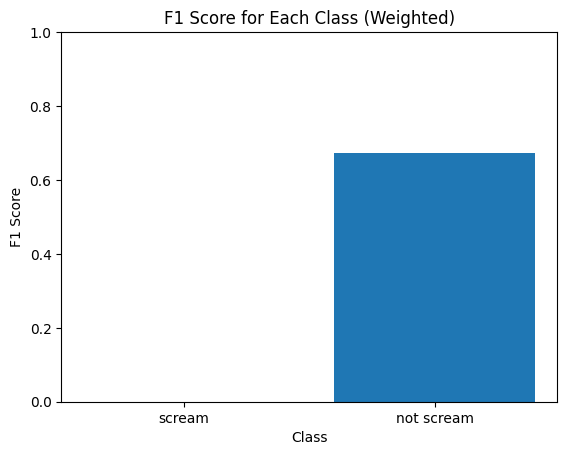

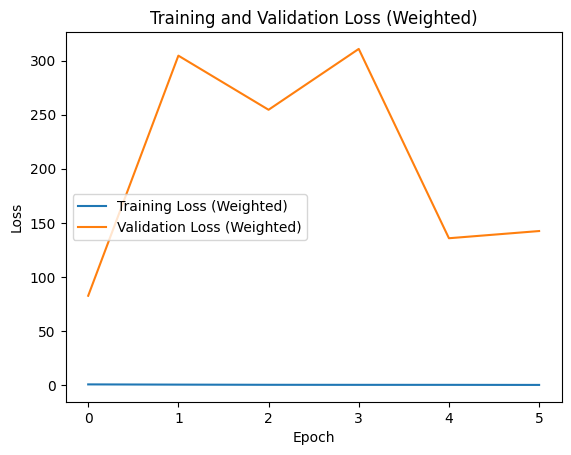

In [9]:
y_pred_val = model.predict(X_LDN_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_LDN_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

3/3 [==============================] - 0s 46ms/step


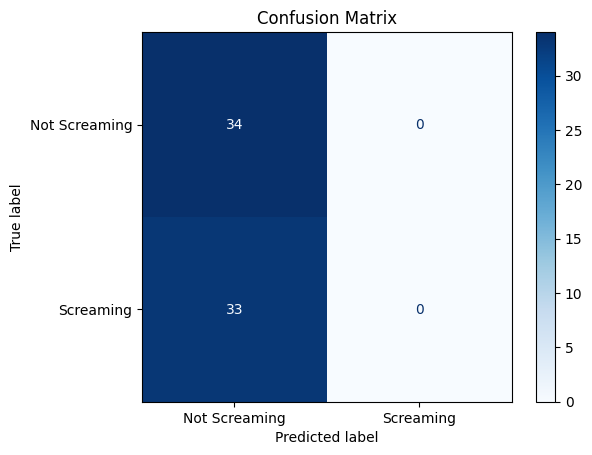

In [10]:
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))

y_pred_prob = model.predict(X_LDN_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_LDN_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Training dataset will be **ONLY** with *New York's* dataset and testing will be **ONLY** with *London's* dataset

### Train

In [11]:
input_shape = (X_NY_train.shape[1], X_NY_train.shape[2], 1)
X_NY_train = X_NY_train.reshape((X_NY_train.shape[0], X_NY_train.shape[1], X_NY_train.shape[2], 1))
X_NY_val = X_NY_val.reshape((X_NY_val.shape[0], X_NY_val.shape[1], X_NY_val.shape[2], 1))
X_LDN_test = X_LDN_test.reshape((X_LDN_test.shape[0], X_LDN_test.shape[1], X_LDN_test.shape[2], 1))

model = create_resnet(input_shape)

y_NY_train_labels = np.argmax(y_NY_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_NY_train_labels), y=y_NY_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

history_weighted = model.fit(X_NY_train, y_NY_train, epochs=50, batch_size=32,
                             validation_data=(X_NY_val, y_NY_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)

Class Weights: {0: 0.822265625, 1: 1.2757575757575759}
Epoch 1/50
132/132 [==============================] - 39s 229ms/step - loss: 0.5412 - accuracy: 0.7646 - val_loss: 4.3838 - val_accuracy: 0.2980
Epoch 2/50
132/132 [==============================] - 24s 183ms/step - loss: 0.4162 - accuracy: 0.8235 - val_loss: 0.8182 - val_accuracy: 0.7593
Epoch 3/50
132/132 [==============================] - 24s 183ms/step - loss: 0.4007 - accuracy: 0.8238 - val_loss: 2.1257 - val_accuracy: 0.7020
Epoch 4/50
132/132 [==============================] - 24s 181ms/step - loss: 0.3585 - accuracy: 0.8511 - val_loss: 3.4209 - val_accuracy: 0.7278
Epoch 5/50
132/132 [==============================] - 24s 182ms/step - loss: 0.3294 - accuracy: 0.8637 - val_loss: 1.4750 - val_accuracy: 0.4441
Epoch 6/50
132/132 [==============================] - 24s 183ms/step - loss: 0.3222 - accuracy: 0.8701 - val_loss: 0.3916 - val_accuracy: 0.8453
Epoch 7/50
132/132 [==============================] - 24s 182ms/step - loss

### Evaluation

In [12]:
loss, accuracy = model.evaluate(X_LDN_test, y_LDN_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_LDN_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_LDN_test, axis=1), y_pred_classes))

3/3 [==============================] - 0s 36ms/step - loss: 0.8885 - accuracy: 0.6765
Test accuracy: 0.6764705777168274
3/3 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        34
           1       0.69      0.65      0.67        34

    accuracy                           0.68        68
   macro avg       0.68      0.68      0.68        68
weighted avg       0.68      0.68      0.68        68



11/11 [==============================] - 1s 50ms/step


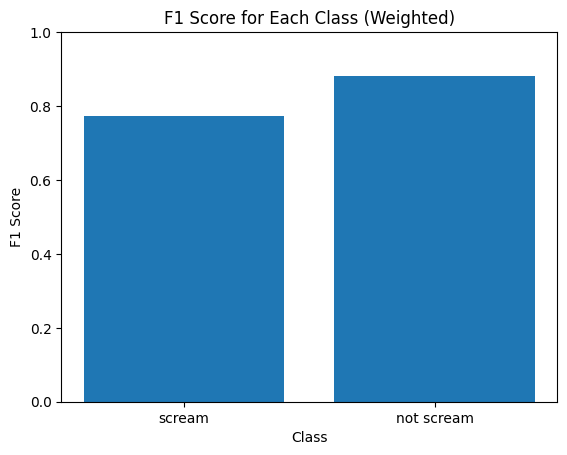

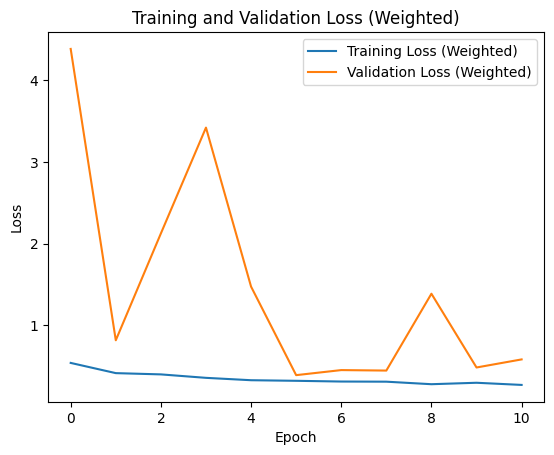

In [13]:
y_pred_val = model.predict(X_NY_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_NY_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

# Plot training history: loss
plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

11/11 [==============================] - 1s 51ms/step


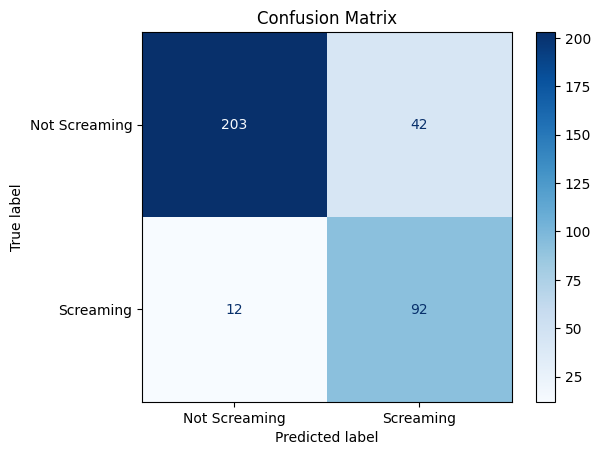

In [14]:
X_NY_val = X_NY_val.reshape((X_NY_val.shape[0], X_NY_val.shape[1], X_NY_val.shape[2], 1))

y_pred_prob = model.predict(X_NY_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_NY_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Training dataset will be **ONLY** of LONDON and testing dataset from New York

### Train

In [15]:
input_shape = (X_LDN_train.shape[1], X_LDN_train.shape[2], 1)
X_LDN_train = X_LDN_train.reshape((X_LDN_train.shape[0], X_LDN_train.shape[1], X_LDN_train.shape[2], 1))
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))
X_NY_test = X_NY_test.reshape((X_NY_test.shape[0], X_NY_test.shape[1], X_NY_test.shape[2], 1))

model = create_resnet(input_shape)

y_LDN_train_labels = np.argmax(y_LDN_train, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_LDN_train_labels), y=y_LDN_train_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

history_weighted = model.fit(X_LDN_train, y_LDN_train, epochs=50, batch_size=32,
                             validation_data=(X_LDN_val, y_LDN_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/50
17/17 [==============================] - 13s 220ms/step - loss: 0.7127 - accuracy: 0.6593 - val_loss: 2.5151 - val_accuracy: 0.5075
Epoch 2/50
17/17 [==============================] - 3s 184ms/step - loss: 0.3920 - accuracy: 0.8593 - val_loss: 318.7202 - val_accuracy: 0.5075
Epoch 3/50
17/17 [==============================] - 3s 189ms/step - loss: 0.2824 - accuracy: 0.8759 - val_loss: 886.6257 - val_accuracy: 0.5075
Epoch 4/50
17/17 [==============================] - 3s 184ms/step - loss: 0.3917 - accuracy: 0.8685 - val_loss: 10.4968 - val_accuracy: 0.2537
Epoch 5/50
17/17 [==============================] - 3s 184ms/step - loss: 0.3760 - accuracy: 0.8685 - val_loss: 36.4938 - val_accuracy: 0.4925
Epoch 6/50
17/17 [==============================] - 3s 187ms/step - loss: 0.3164 - accuracy: 0.8741 - val_loss: 78.0377 - val_accuracy: 0.4925


### Evaluation

In [16]:
loss, accuracy = model.evaluate(X_NY_test, y_NY_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_NY_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_NY_test, axis=1), y_pred_classes))

11/11 [==============================] - 2s 218ms/step - loss: 4.2255 - accuracy: 0.3029
Test accuracy: 0.3028571307659149
11/11 [==============================] - 1s 50ms/step
              precision    recall  f1-score   support

           0       0.60      0.10      0.17       252
           1       0.26      0.83      0.40        98

    accuracy                           0.30       350
   macro avg       0.43      0.46      0.28       350
weighted avg       0.50      0.30      0.23       350



3/3 [==============================] - 0s 44ms/step


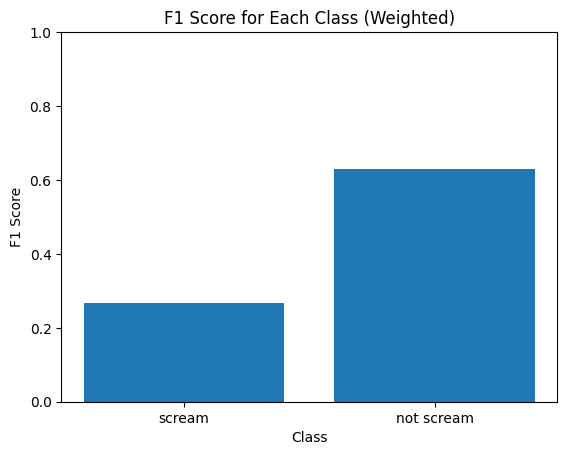

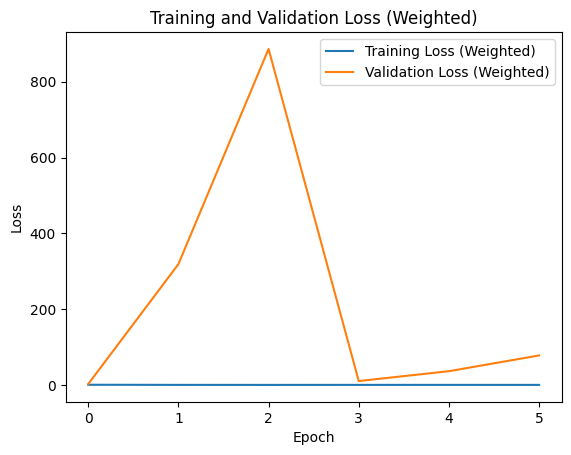

In [17]:
y_pred_val = model.predict(X_LDN_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_LDN_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

3/3 [==============================] - 0s 43ms/step


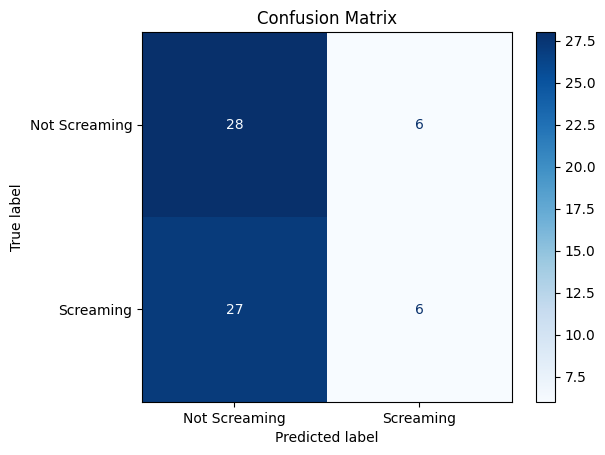

In [18]:
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))

y_pred_prob = model.predict(X_LDN_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_LDN_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Training dataset New York + 30% of London's dataset, Validation Dataset London, Testing dataset London

Here, we combine the training files from New York with 30% of the training dataset from London. This approach allows us to fine-tune the model, improving its prediction accuracy for the London audio dataset. The validation will be performed using London’s validation dataset to ensure the model works efficiently in London.

In [7]:
num_samples = int(0.3 * len(X_LDN_train))

X_LDN_train_subset = X_LDN_train[:num_samples]
y_LDN_train_subset = y_LDN_train[:num_samples]

print('Original X_LDN_train shape:', X_LDN_train.shape)
print('Subset X_LDN_train shape:', X_LDN_train_subset.shape)
print('Original y_LDN_train shape:', y_LDN_train.shape)
print('Subset y_LDN_train shape:', y_LDN_train_subset.shape)

Original X_LDN_train shape: (540, 1001, 128)
Subset X_LDN_train shape: (162, 1001, 128)
Original y_LDN_train shape: (540, 2)
Subset y_LDN_train shape: (162, 2)


In [8]:
X_train_combined = np.concatenate((X_NY_train, X_LDN_train), axis=0)
y_train_combined = np.concatenate((y_NY_train, y_LDN_train), axis=0)

print('y_NY_train shape:', y_NY_train.shape)
print('y_LDN_train shape:', y_LDN_train.shape)
print('Combined y_train shape:', y_train_combined.shape)

y_NY_train shape: (4210, 2)
y_LDN_train shape: (540, 2)
Combined y_train shape: (4750, 2)


### Train the model with New York's training dataset with 30% of London's training dataset.

In [9]:
input_shape = (X_train_combined.shape[1], X_train_combined.shape[2], 1)
X_train_combined = X_train_combined.reshape((X_train_combined.shape[0], X_train_combined.shape[1], X_train_combined.shape[2], 1))
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))
X_LDN_test = X_LDN_test.reshape((X_LDN_test.shape[0], X_LDN_test.shape[1], X_LDN_test.shape[2], 1))

model = create_resnet(input_shape)

y_train_combined_labels = np.argmax(y_train_combined, axis=1)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_combined_labels), y=y_train_combined_labels)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

history_weighted = model.fit(X_train_combined, y_train_combined, epochs=50, batch_size=32,
                             validation_data=(X_LDN_val, y_LDN_val),
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                             class_weight=class_weights_dict)

Class Weights: {0: 0.8392226148409894, 1: 1.2369791666666667}
Epoch 1/50
149/149 [==============================] - 53s 216ms/step - loss: 0.5509 - accuracy: 0.7571 - val_loss: 6.1532 - val_accuracy: 0.4925
Epoch 2/50
149/149 [==============================] - 27s 181ms/step - loss: 0.4580 - accuracy: 0.8063 - val_loss: 0.6926 - val_accuracy: 0.5224
Epoch 3/50
149/149 [==============================] - 27s 180ms/step - loss: 0.4286 - accuracy: 0.8158 - val_loss: 1.0591 - val_accuracy: 0.6418
Epoch 4/50
149/149 [==============================] - 27s 179ms/step - loss: 0.4038 - accuracy: 0.8326 - val_loss: 5.7697 - val_accuracy: 0.5075
Epoch 5/50
149/149 [==============================] - 27s 179ms/step - loss: 0.3839 - accuracy: 0.8474 - val_loss: 0.9590 - val_accuracy: 0.6716
Epoch 6/50
149/149 [==============================] - 27s 179ms/step - loss: 0.3586 - accuracy: 0.8531 - val_loss: 4.9974 - val_accuracy: 0.5075
Epoch 7/50
149/149 [==============================] - 27s 179ms/step

### Evaluation

In [10]:
loss, accuracy = model.evaluate(X_LDN_test, y_LDN_test)
print(f'Test accuracy: {accuracy}')

y_pred = model.predict(X_LDN_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(np.argmax(y_LDN_test, axis=1), y_pred_classes))

3/3 [==============================] - 1s 373ms/step - loss: 0.1837 - accuracy: 0.9265
Test accuracy: 0.9264705777168274
3/3 [==============================] - 0s 46ms/step
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        34
           1       0.87      1.00      0.93        34

    accuracy                           0.93        68
   macro avg       0.94      0.93      0.93        68
weighted avg       0.94      0.93      0.93        68



3/3 [==============================] - 0s 45ms/step


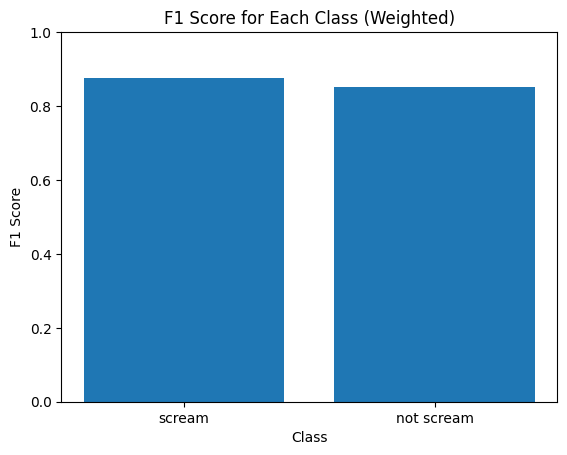

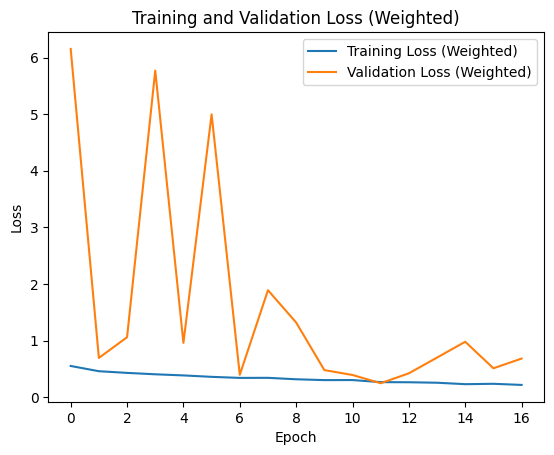

In [11]:
y_pred_val = model.predict(X_LDN_val)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
f1_scores_weighted = classification_report(np.argmax(y_LDN_val, axis=1), y_pred_val_classes,
                                           target_names=['not scream', 'scream'],
                                           output_dict=True)

f1_scream_weighted = f1_scores_weighted['scream']['f1-score']
f1_not_scream_weighted = f1_scores_weighted['not scream']['f1-score']

plt.bar(['scream', 'not scream'], [f1_scream_weighted, f1_not_scream_weighted])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Class (Weighted)')
plt.ylim(0, 1.0)
plt.show()

plt.plot(history_weighted.history['loss'], label='Training Loss (Weighted)')
plt.plot(history_weighted.history['val_loss'], label='Validation Loss (Weighted)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Weighted)')
plt.show()

3/3 [==============================] - 0s 45ms/step


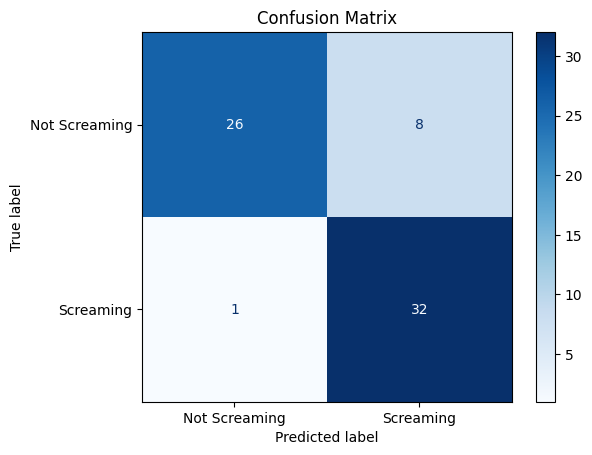

In [12]:
X_LDN_val = X_LDN_val.reshape((X_LDN_val.shape[0], X_LDN_val.shape[1], X_LDN_val.shape[2], 1))

y_pred_prob = model.predict(X_LDN_val)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(np.argmax(y_LDN_val, axis=1), y_pred)

labels = ['Not Screaming', 'Screaming']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()